# Hourly PSDS - 

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path

import os
import pickle
import matplotlib.pyplot as plt

from functions.get_fband_average import __get_fband_average

In [2]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero

    min_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])

    return min_psd

In [3]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:, f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [4]:
def __get_minimum_psd(psds, f_tmp):

    for i, psd in enumerate(psds):
        if i == 0:
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum()

        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    return psds[idx]

In [5]:
def __get_array_from_dataframe(df):

    from pandas import to_numeric

    ## convert to list
    psds = []
    for col in array(df.columns):

        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [7]:
## ---------------------------------------

name = "FFBI"
inname = "2023_FFBI_3600"
subdir = "FFBI_absolute/"
threshold = 1e8
f_limits = 0.001, 1.0


## ---------------------------------------

path = data_path+f"LNM2/PSDS/"

## load configurations
config = pickle.load(open(path+subdir+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = path+subdir
config['f_limits'] = f_limits
config['thres'] = threshold
config['station'] = name

config['outpath_figures'] = data_path+f"LNM2/figures/{subdir}"

config['period_limits'] = [1/config['f_limits'][1], 1/config['f_limits'][0]]


In [8]:
!ls /import/kilauea-data/LNM2/PSDS/FFBI_absolute

ls: cannot access '/import/kilauea-data/LNM2/PSDS/FFBI_absolute': No such file or directory


## Methods

In [9]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [10]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [11]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [12]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [13]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)



    ##____________________________


    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

    axes.set_ylim(1e-11, 1e2)
    axes.set_xlim(1e-3, 2e1)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    _name = config['inpath'].split('_')[1][:-1]
    axes.set_ylabel(f"{_name} Air Pressure PSD ($hPa^2$/$Hz)$", fontsize=font)
    # axes.set_ylabel(r"PSD$_{infrasound}$ ($hPa$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))

    axes.set_title(f"{config['station']} | {day}")

    plt.show();
    return fig

In [14]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)


    ##____________________________

    NN = 3

    fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

#     N = max(psds[0].shape[0], psds[1].shape[0], psds[2].shape[0])
#     colors = plt.cm.rainbow(linspace(0, 1, N))

    N =24
    colors = plt.cm.rainbow(linspace(0,1,N))
    cmap = plt.get_cmap('rainbow', 24)


    ## add Frequency Axis
#     g = lambda x: 1/x
#     ax2 = axes[0].secondary_xaxis("top", functions=(g,g))
#     ax2.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)
#     ax2.set_xticklabels(ff[2], fontsize=11)
#     ax2.tick_params(axis='both', labelsize=font-2)


    for j in range(NN):
        for n, psd in enumerate(tqdm(psds[j])):
            axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
            p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N)

        for reject in rejected[j]:
             axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=1)

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")


        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)

    axes[0].set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
    axes[1].set_ylabel(r"PSD$_{north}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
    axes[2].set_ylabel(r"PSD$_{east}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

## RUN for all files 

2023_FFBI_3600_20230923_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


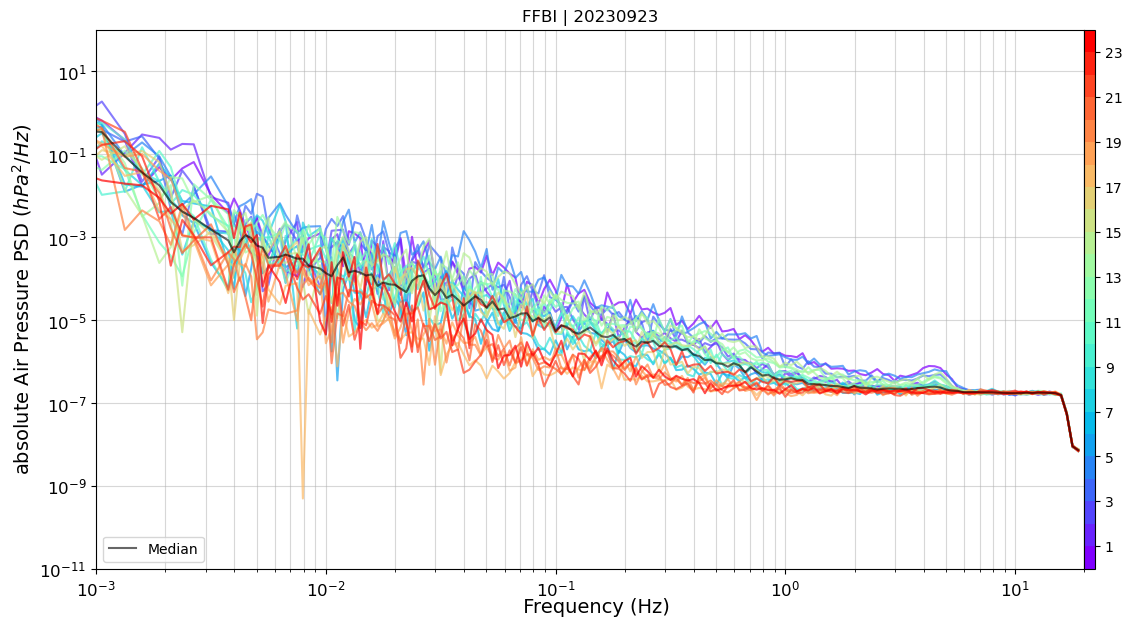

2023_FFBI_3600_20230924_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


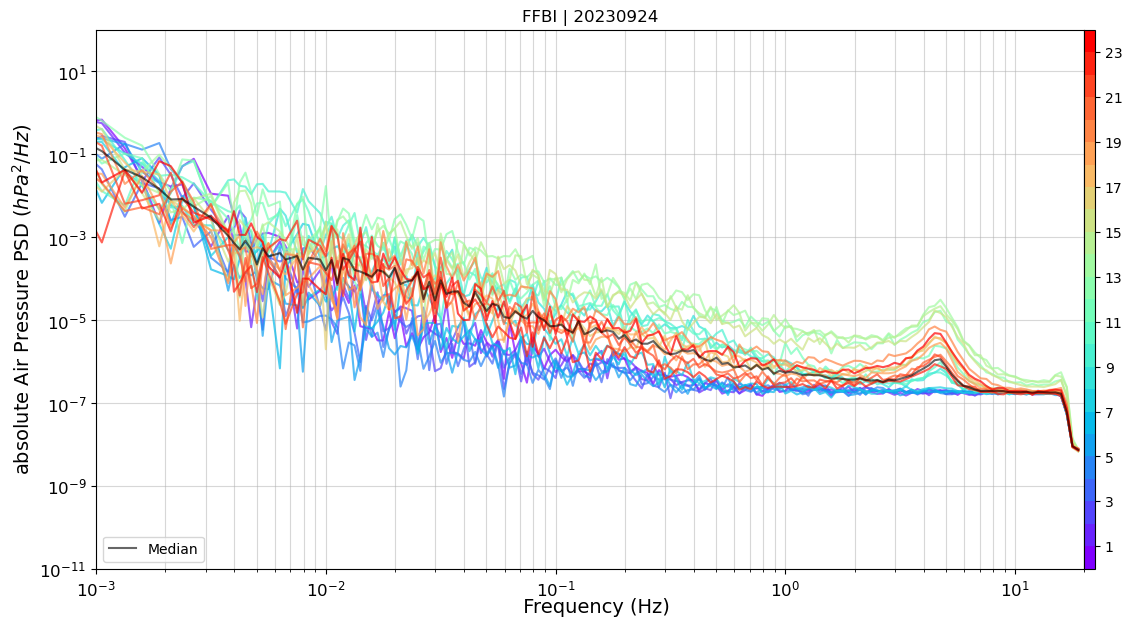

2023_FFBI_3600_20230925_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


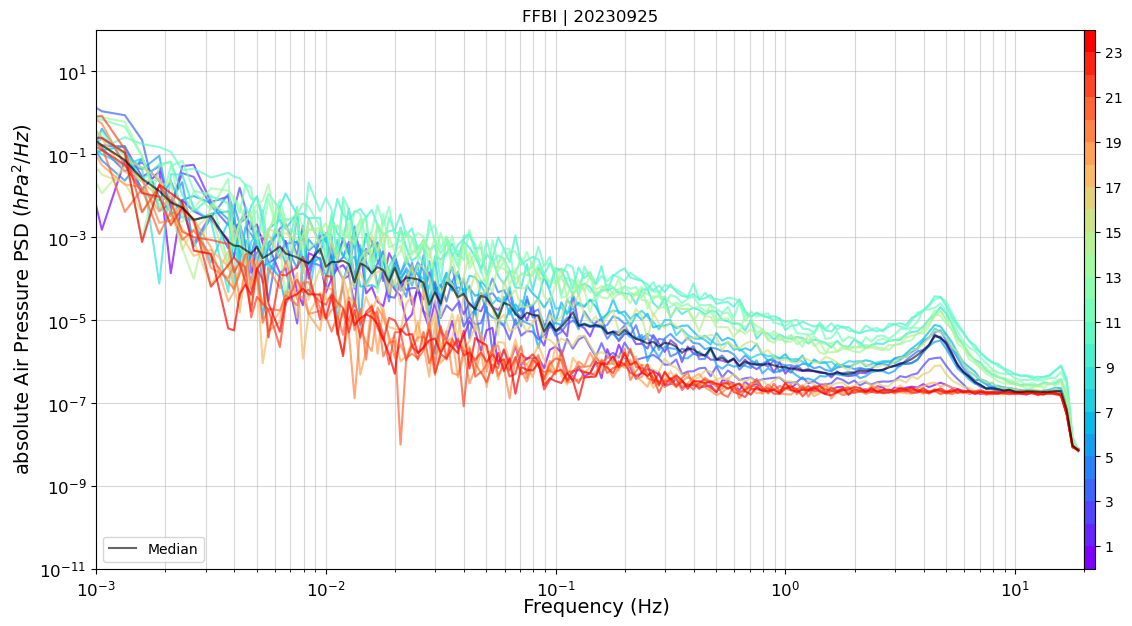

2023_FFBI_3600_20230926_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


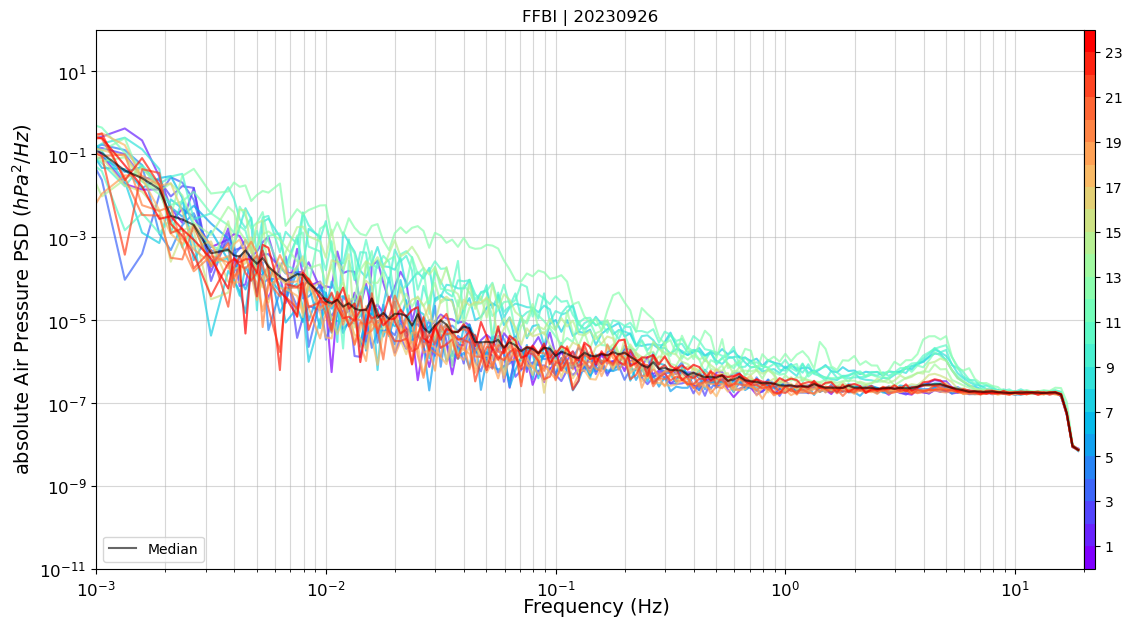

2023_FFBI_3600_20230927_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


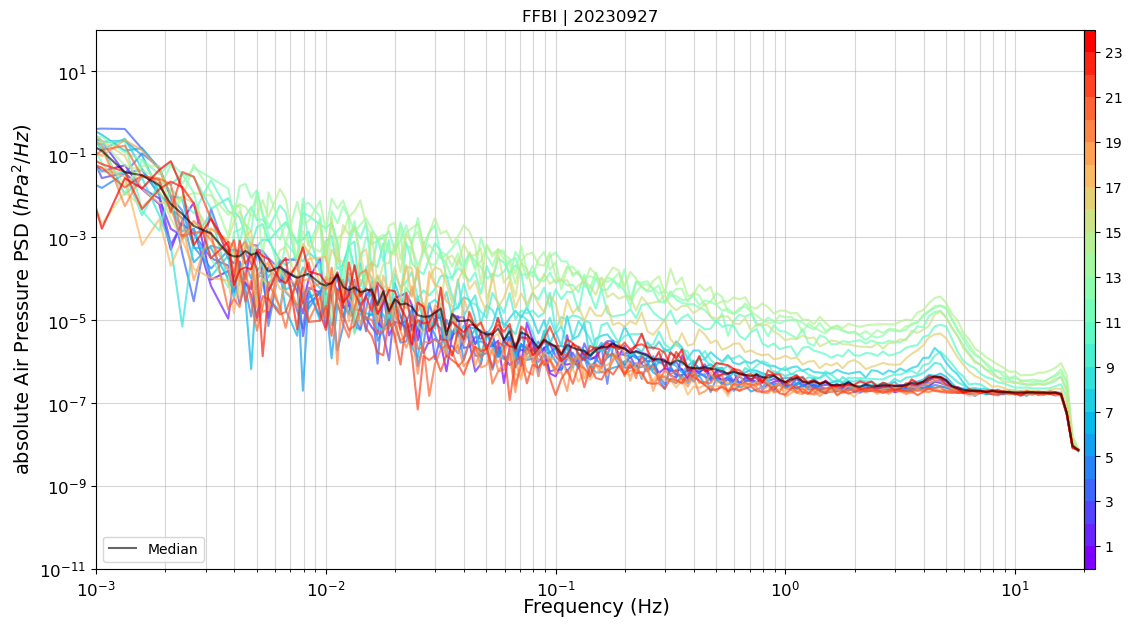

2023_FFBI_3600_20230928_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


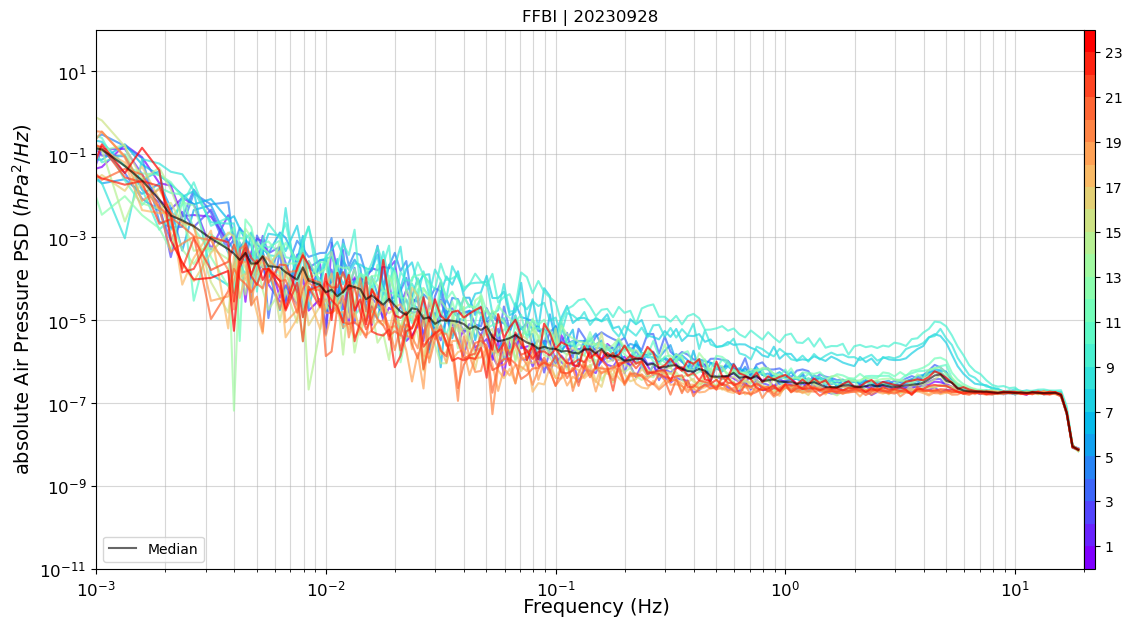

2023_FFBI_3600_20230929_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


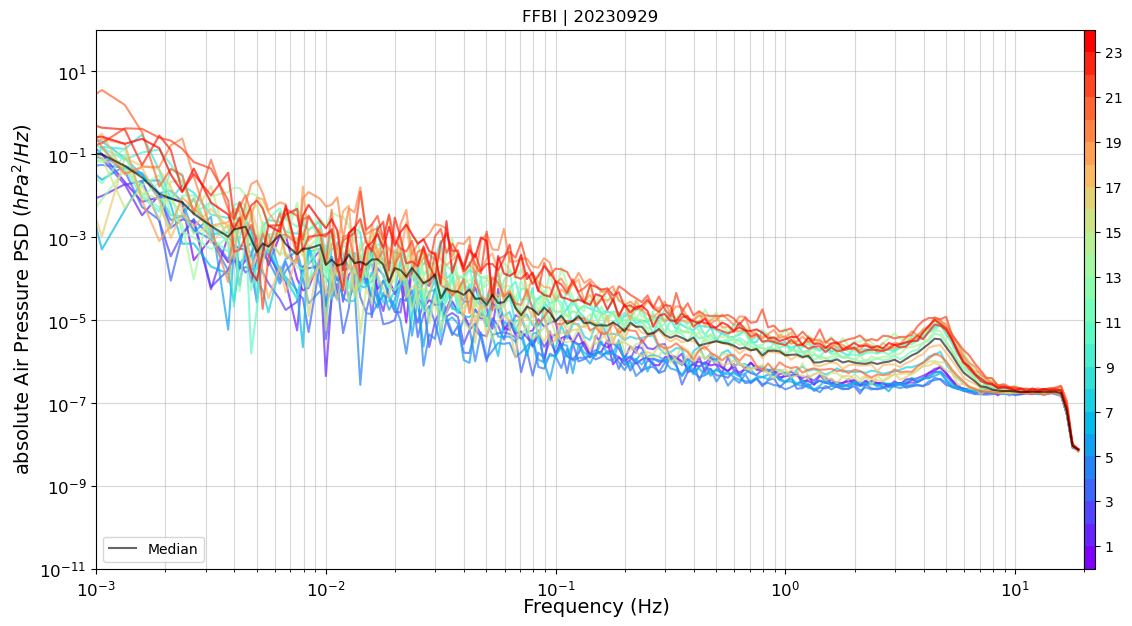

2023_FFBI_3600_20230930_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


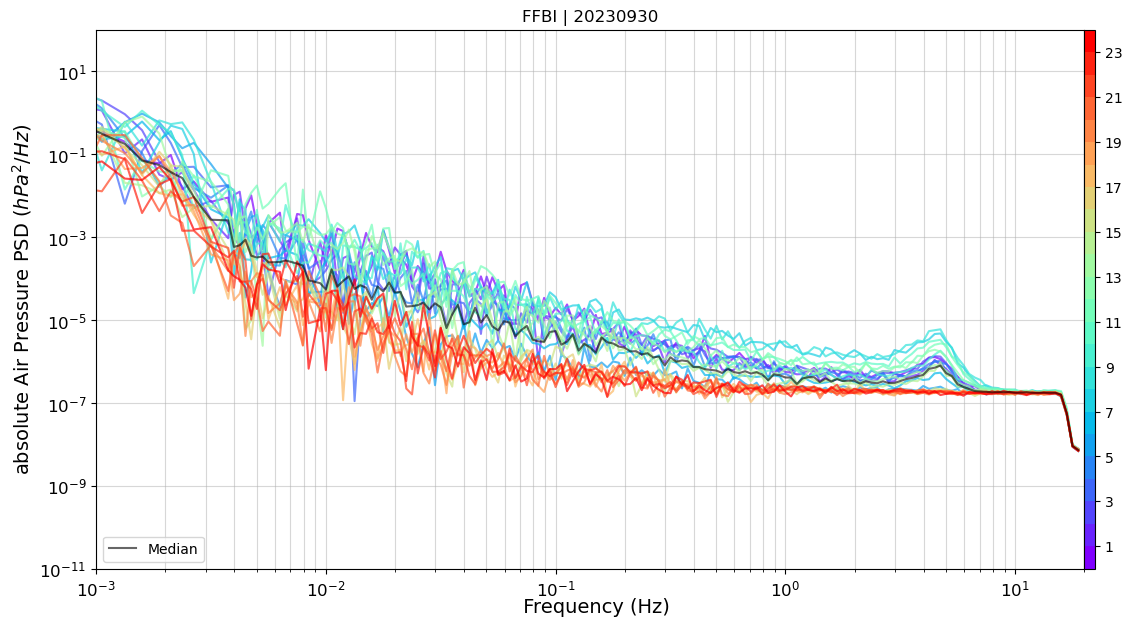

2023_FFBI_3600_20231001_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


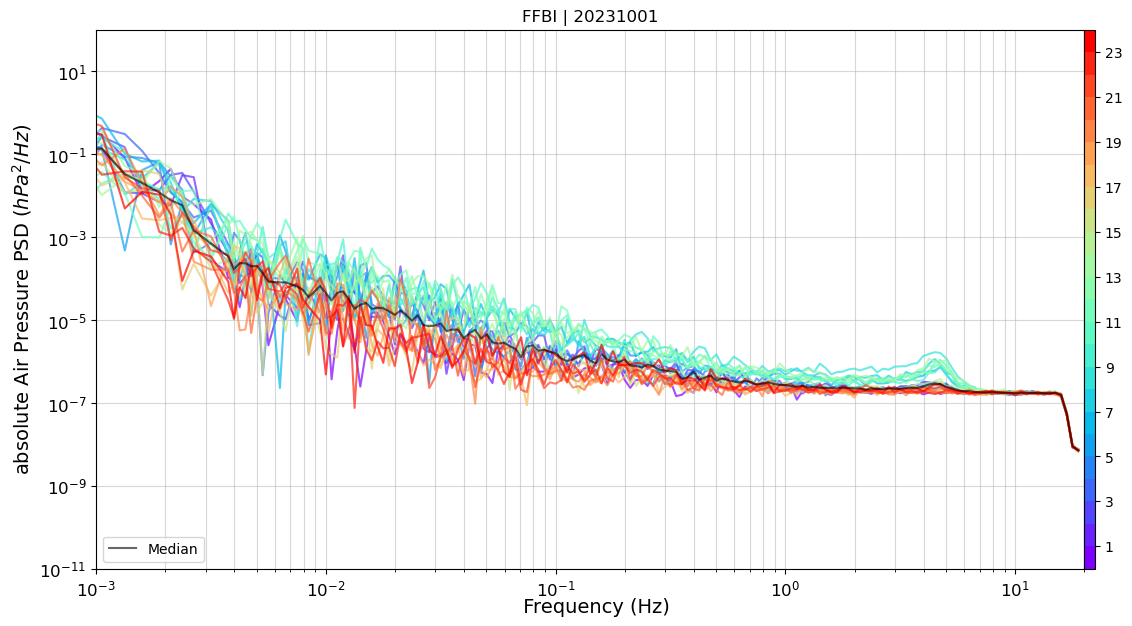

2023_FFBI_3600_20231002_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


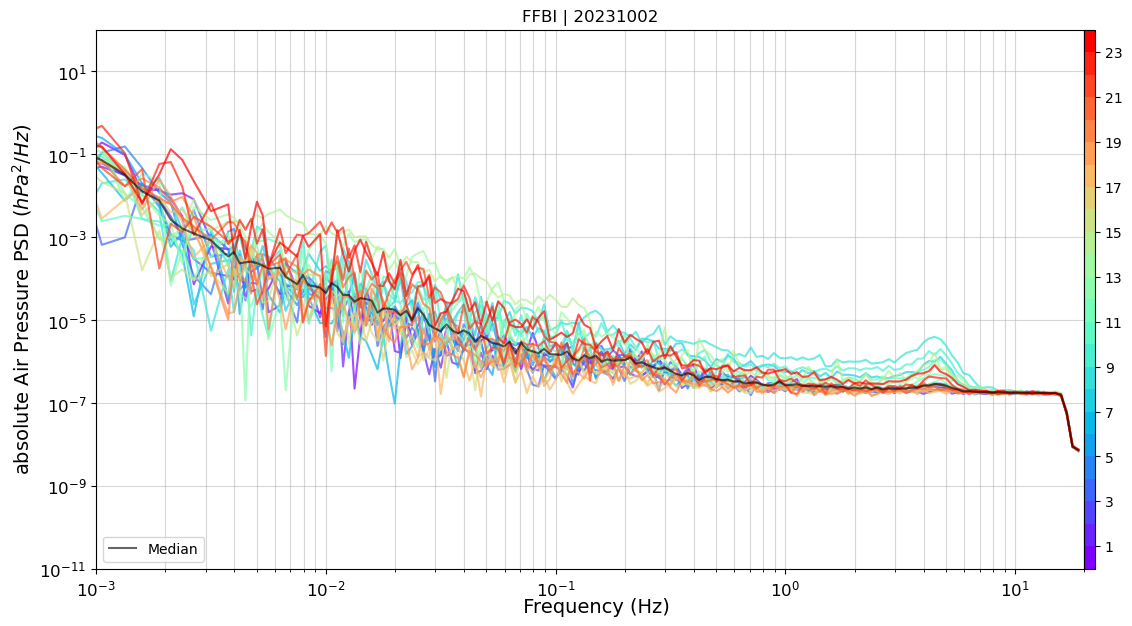

2023_FFBI_3600_20231003_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


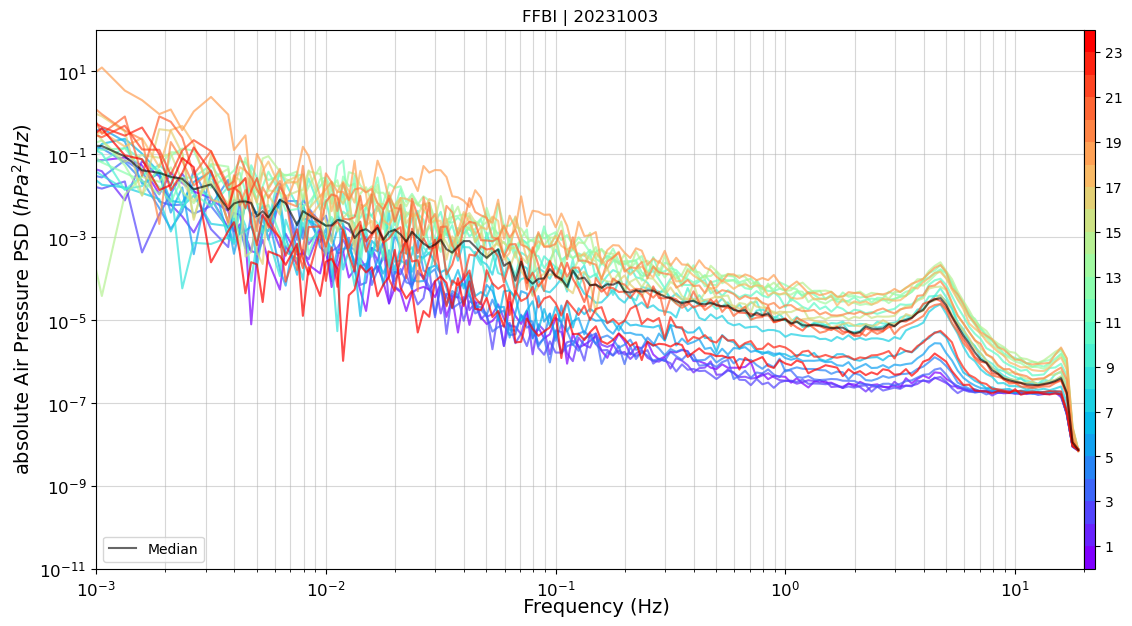

2023_FFBI_3600_20231004_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


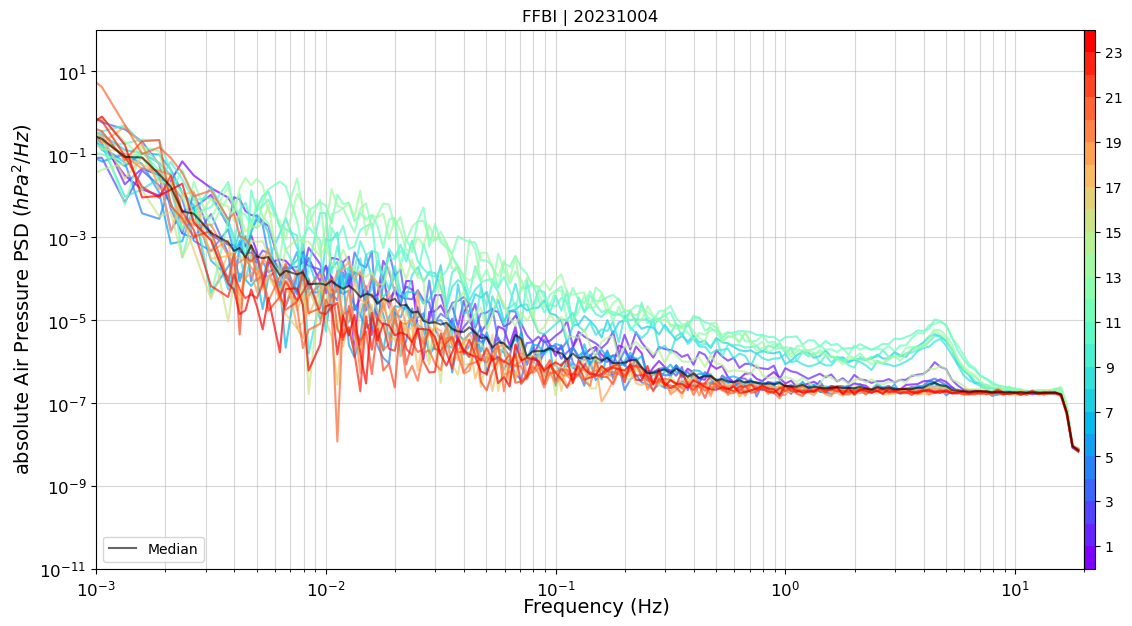

2023_FFBI_3600_20231005_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


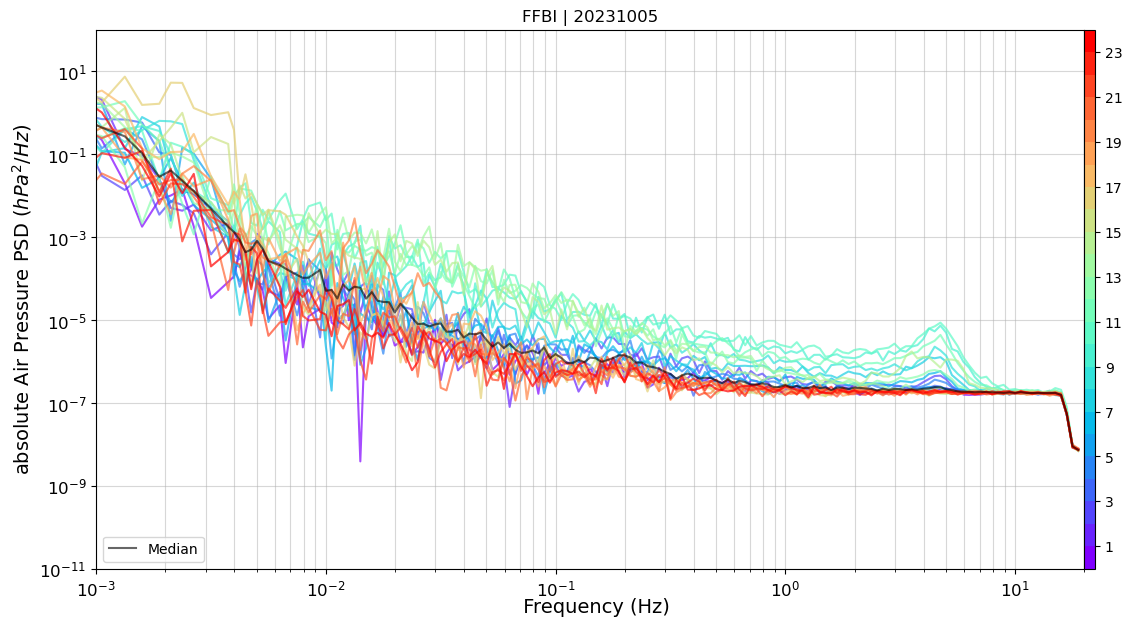

2023_FFBI_3600_20231006_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


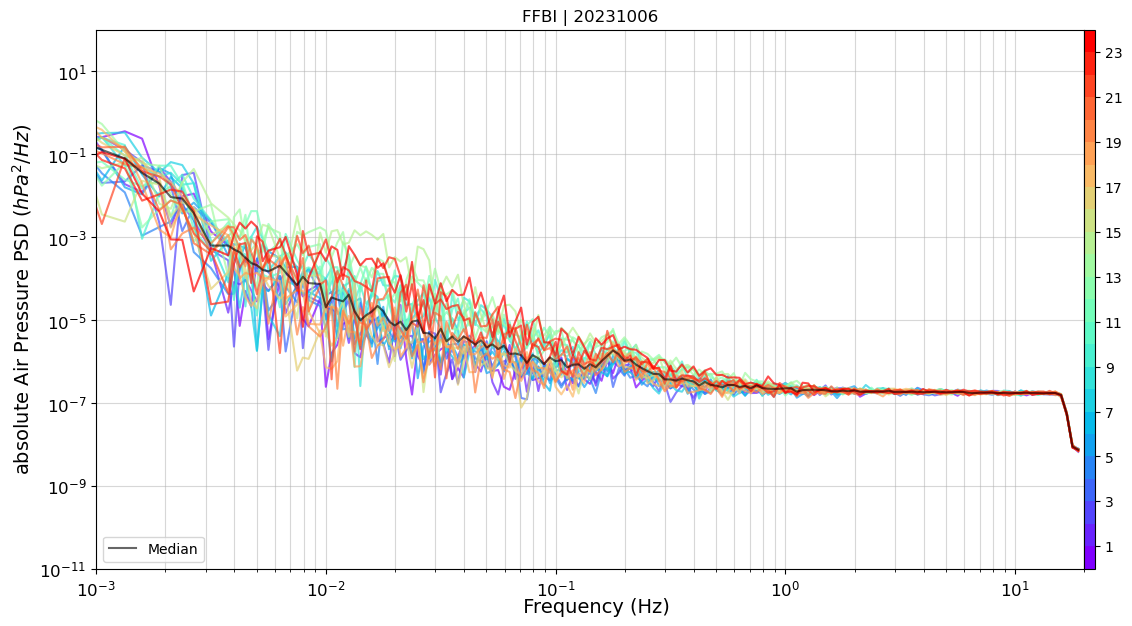

2023_FFBI_3600_20231007_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


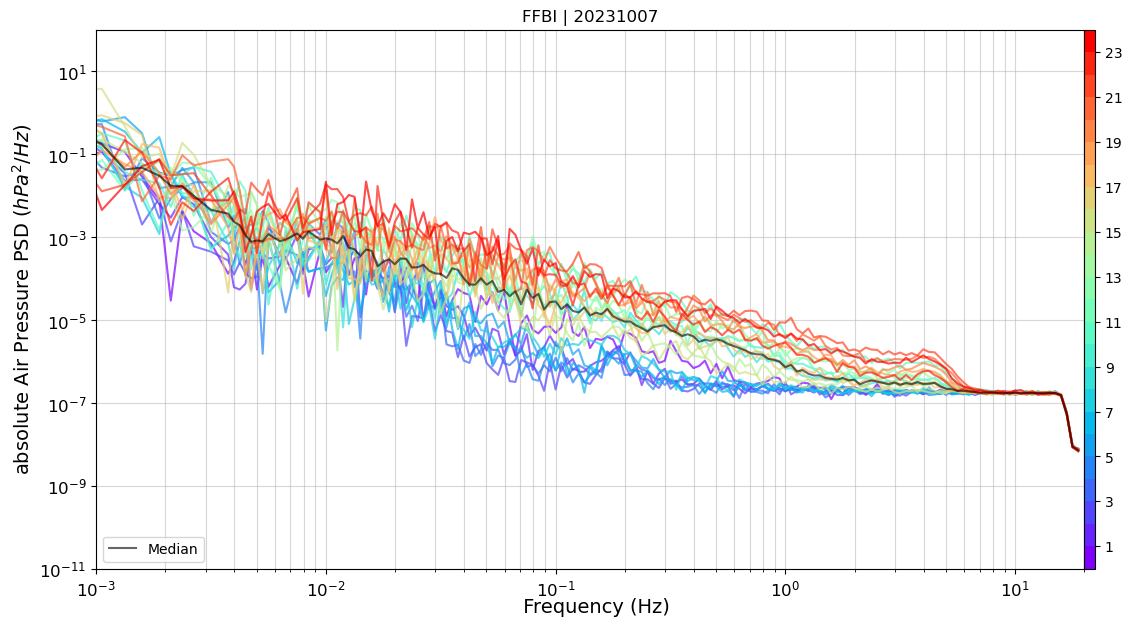

2023_FFBI_3600_20231008_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


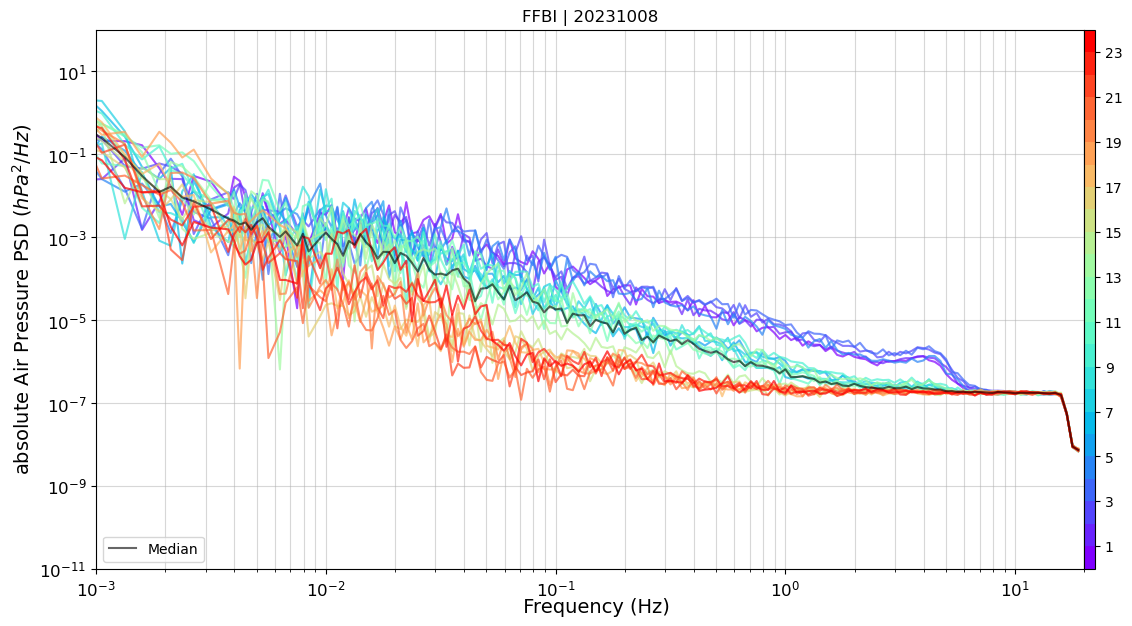

2023_FFBI_3600_20231009_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


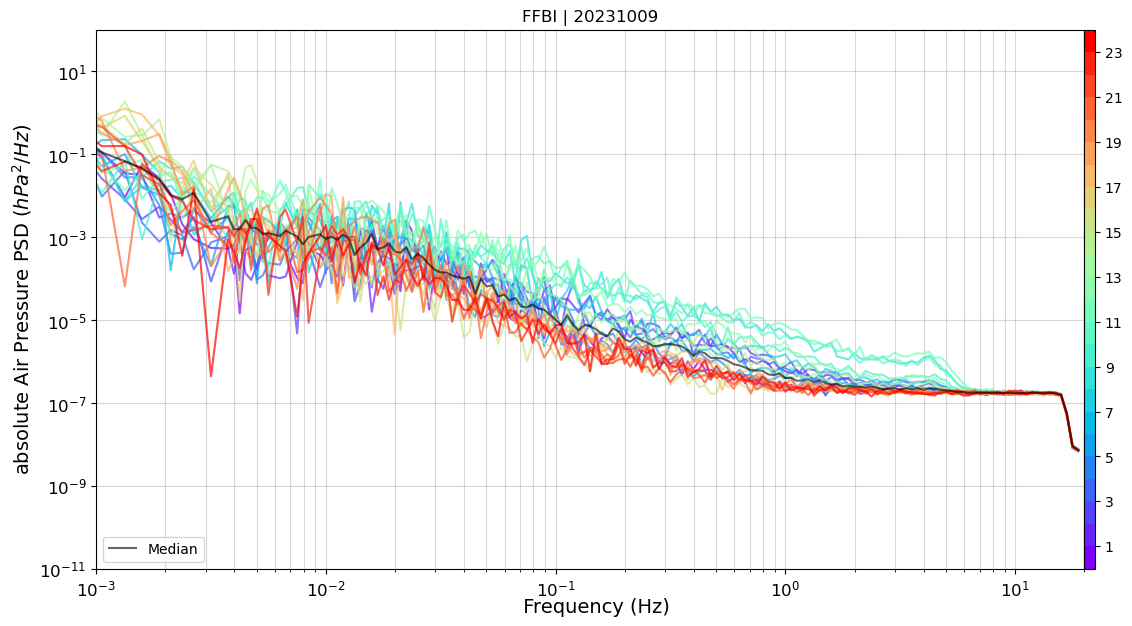

2023_FFBI_3600_20231010_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


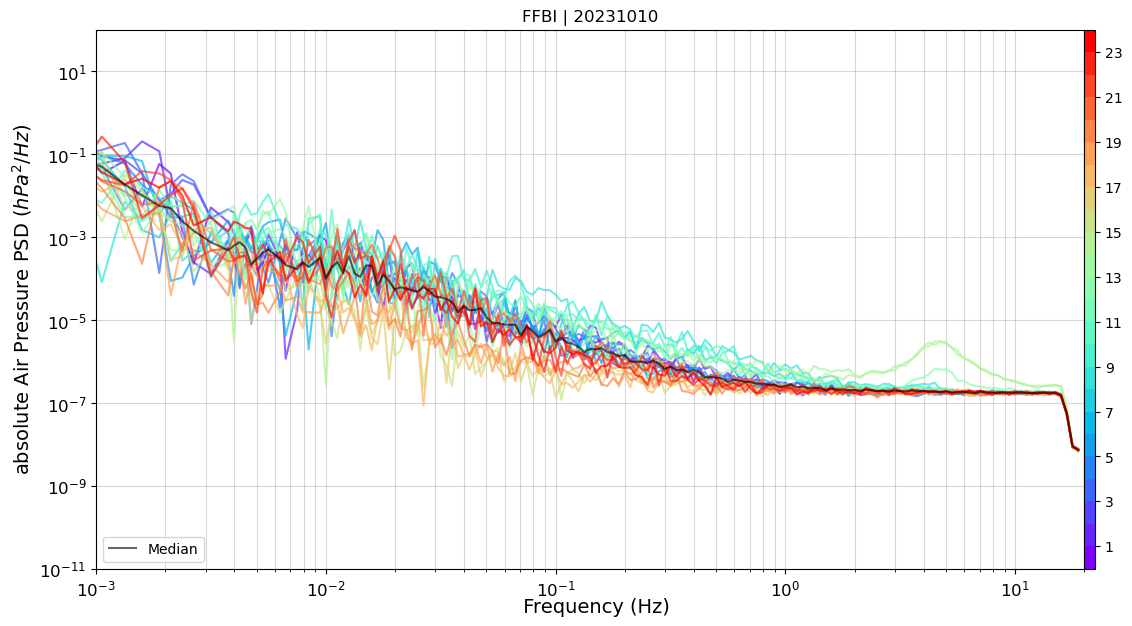

2023_FFBI_3600_20231011_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


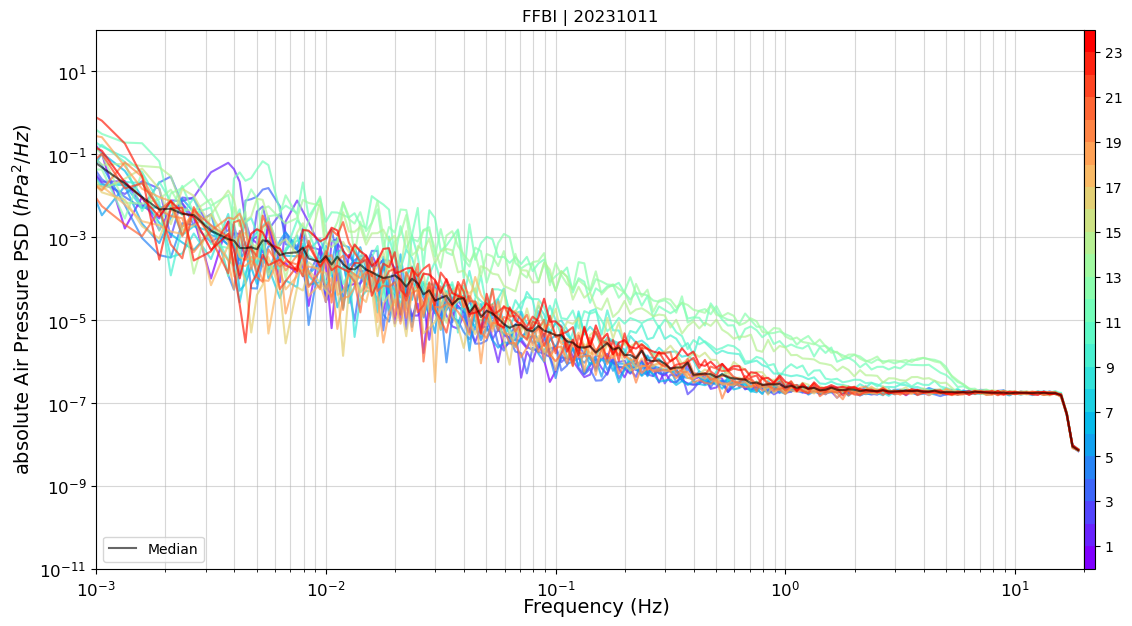

2023_FFBI_3600_20231012_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


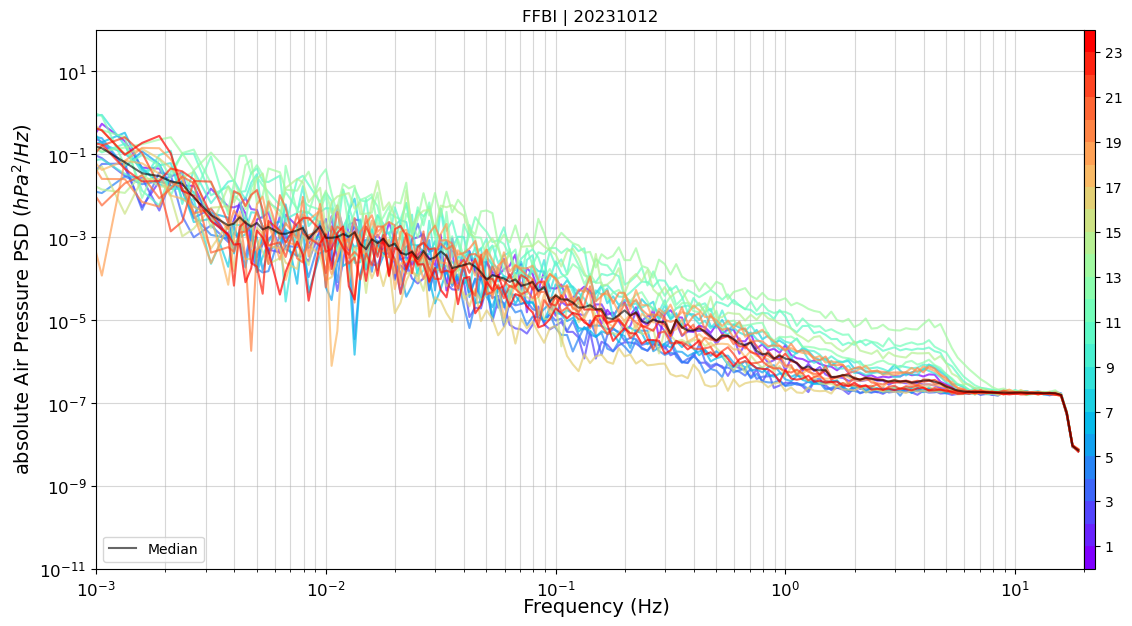

2023_FFBI_3600_20231013_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


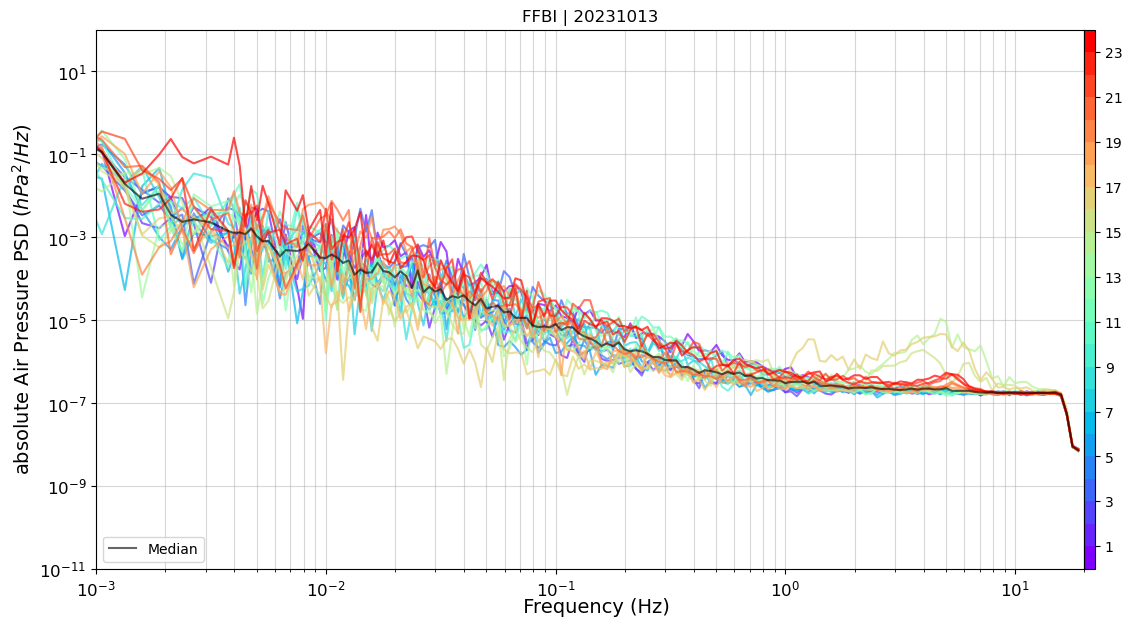

2023_FFBI_3600_20231014_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


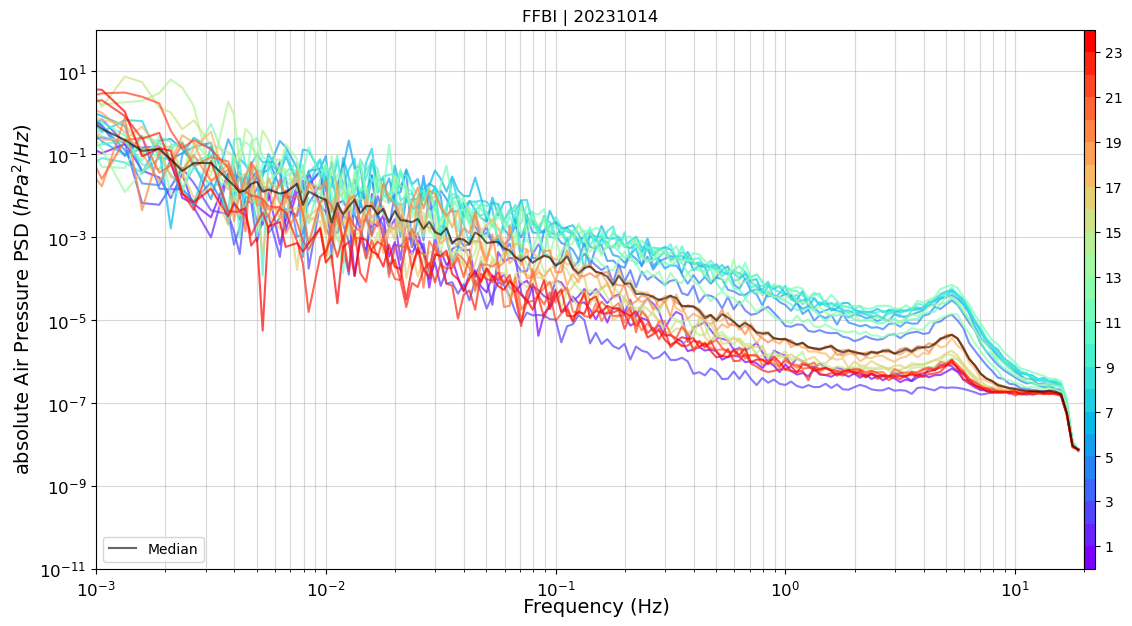

2023_FFBI_3600_20231015_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


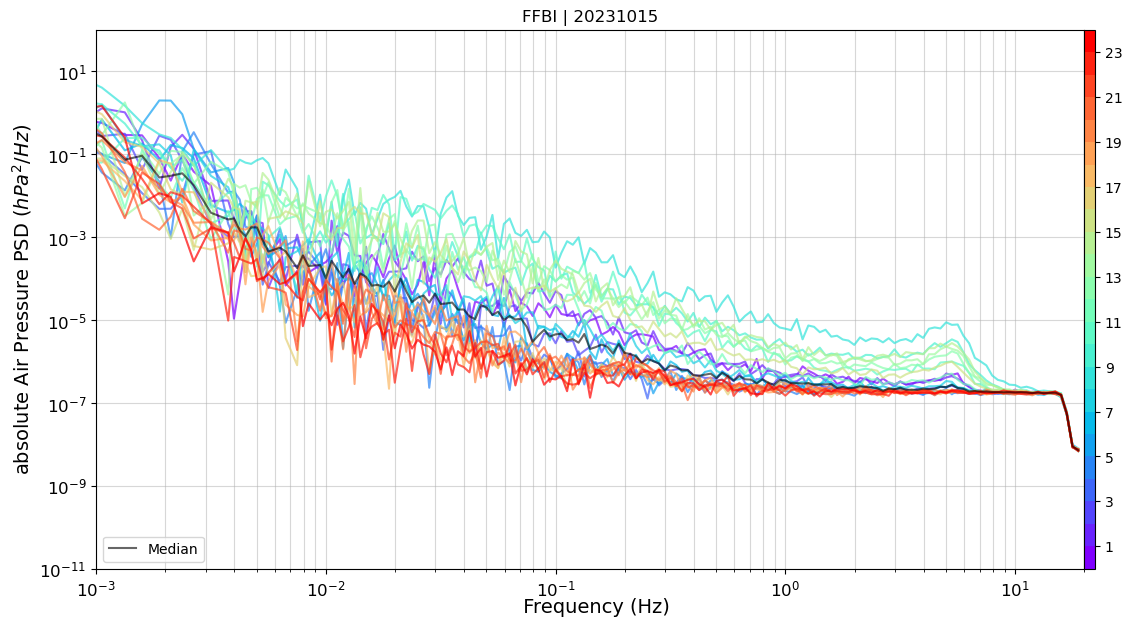

2023_FFBI_3600_20231016_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


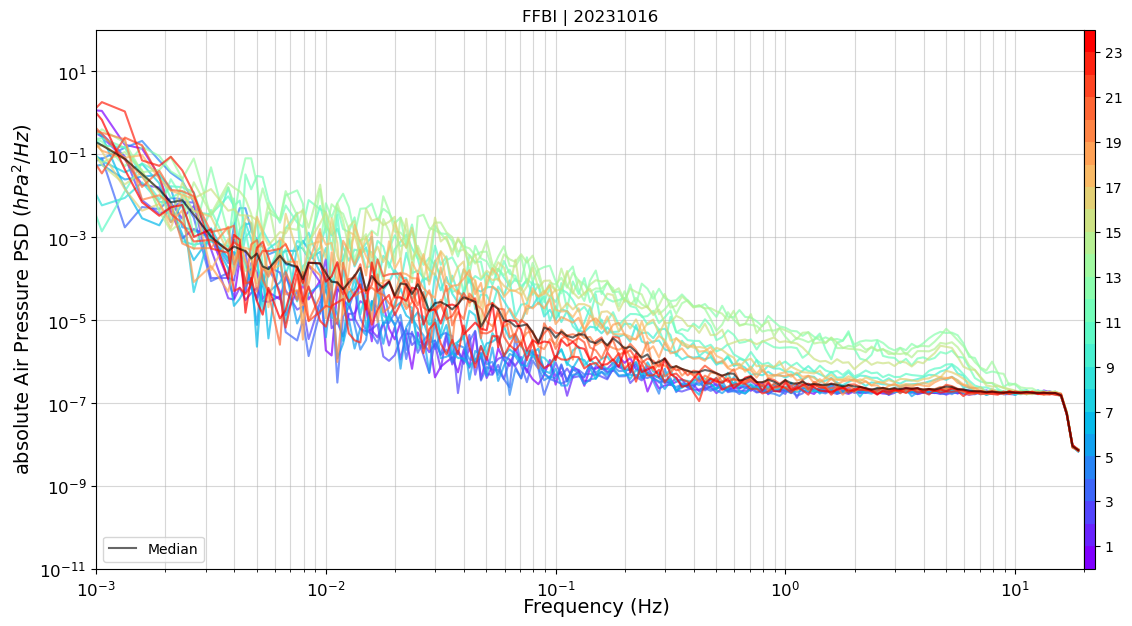

2023_FFBI_3600_20231017_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


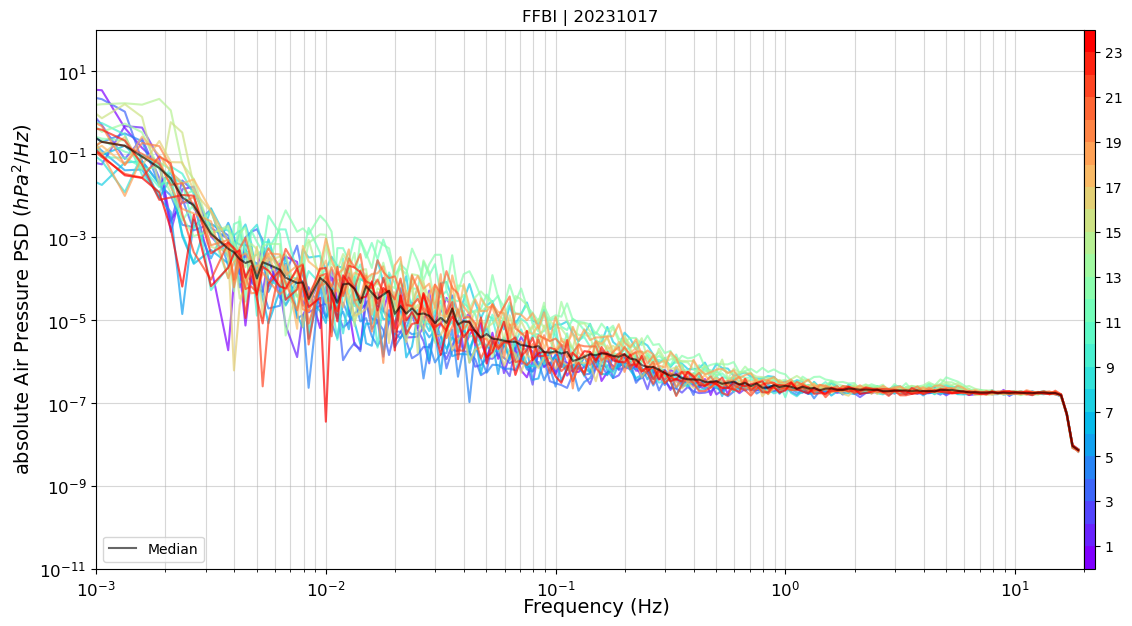

2023_FFBI_3600_20231018_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


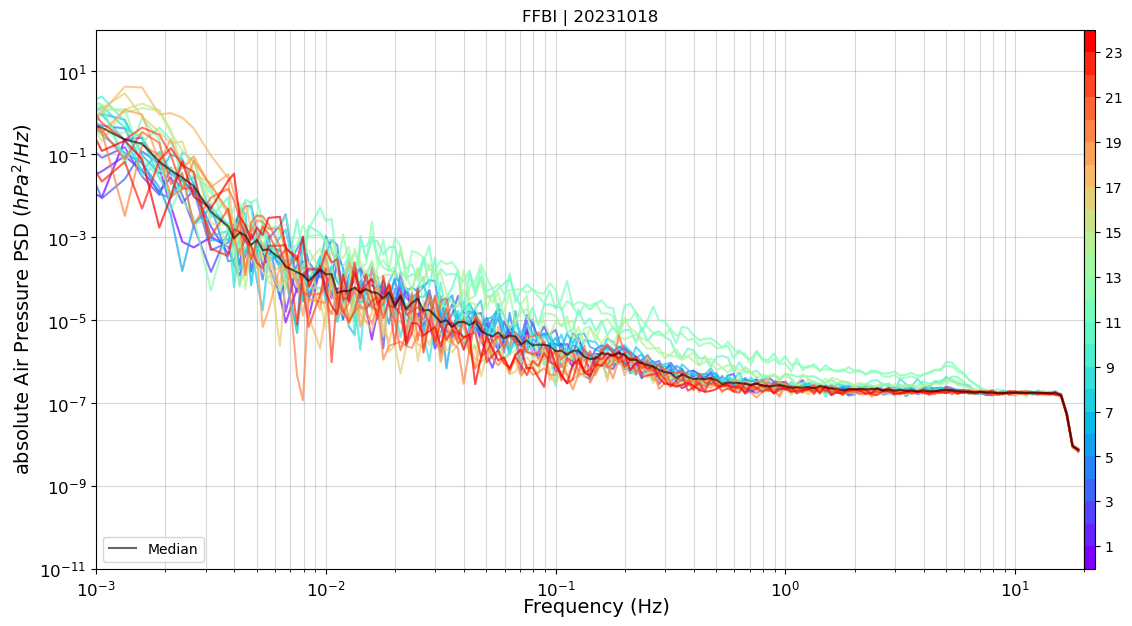

2023_FFBI_3600_20231019_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


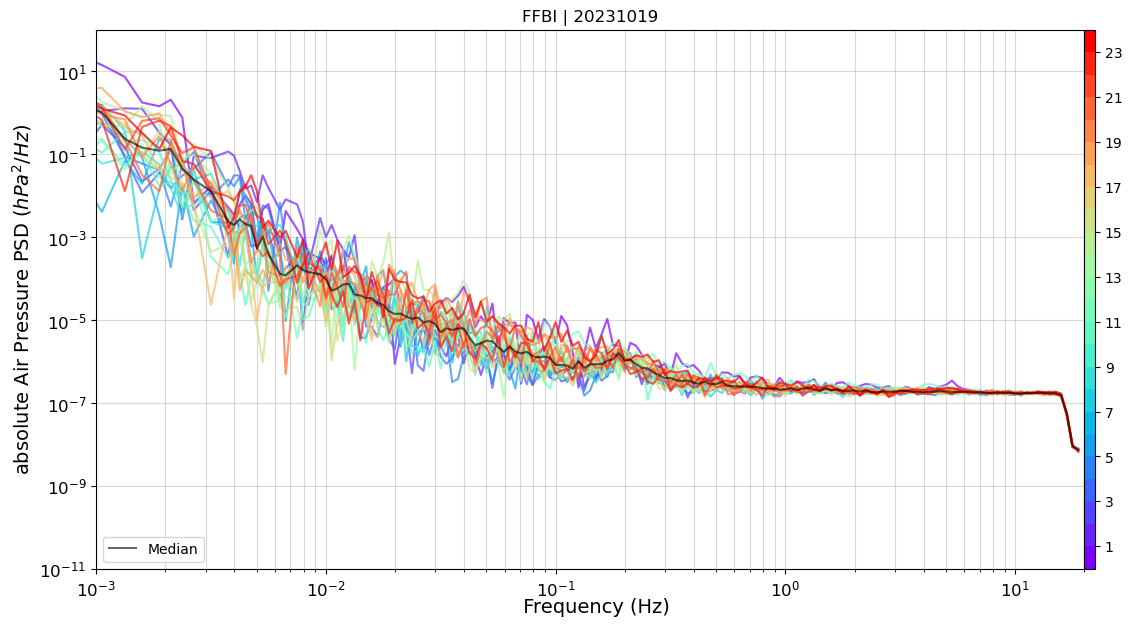

2023_FFBI_3600_20231020_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


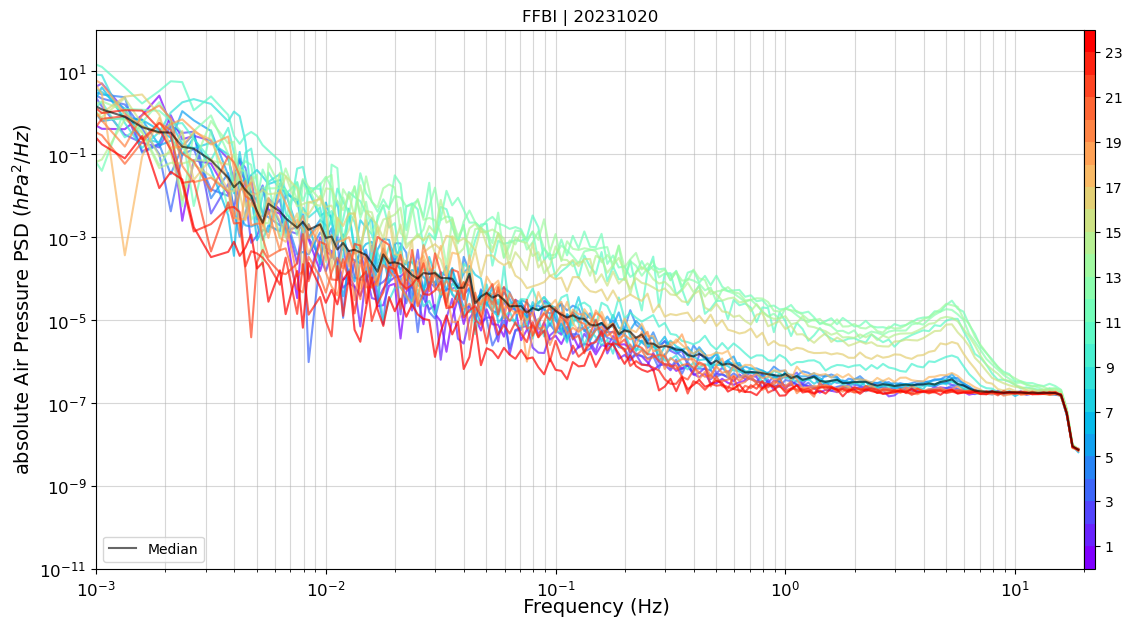

2023_FFBI_3600_20231021_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


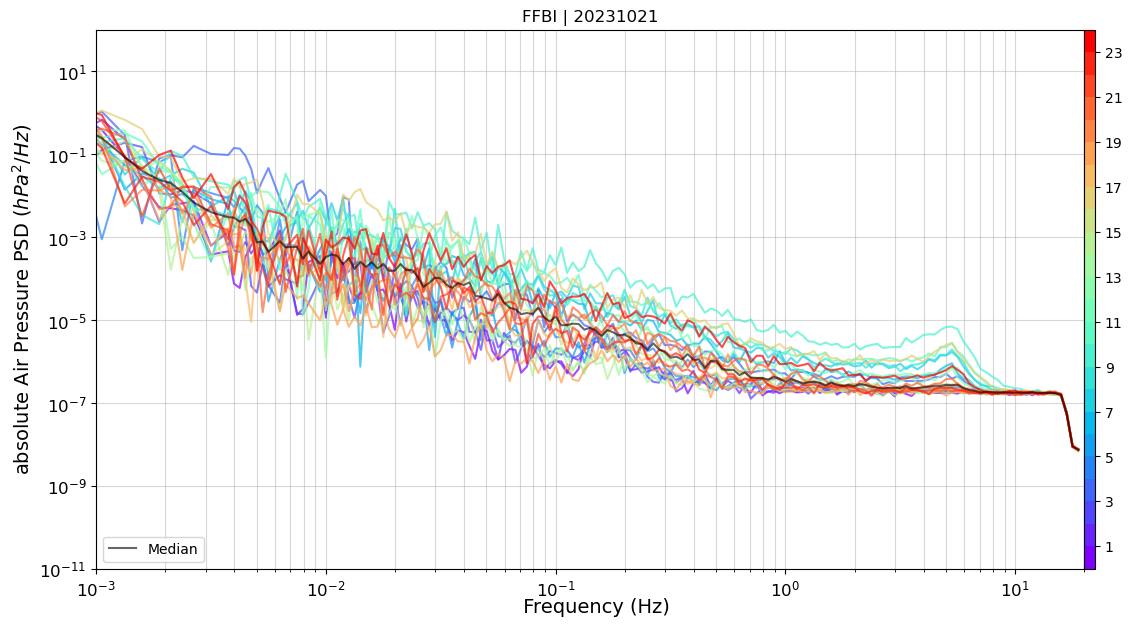

2023_FFBI_3600_20231022_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


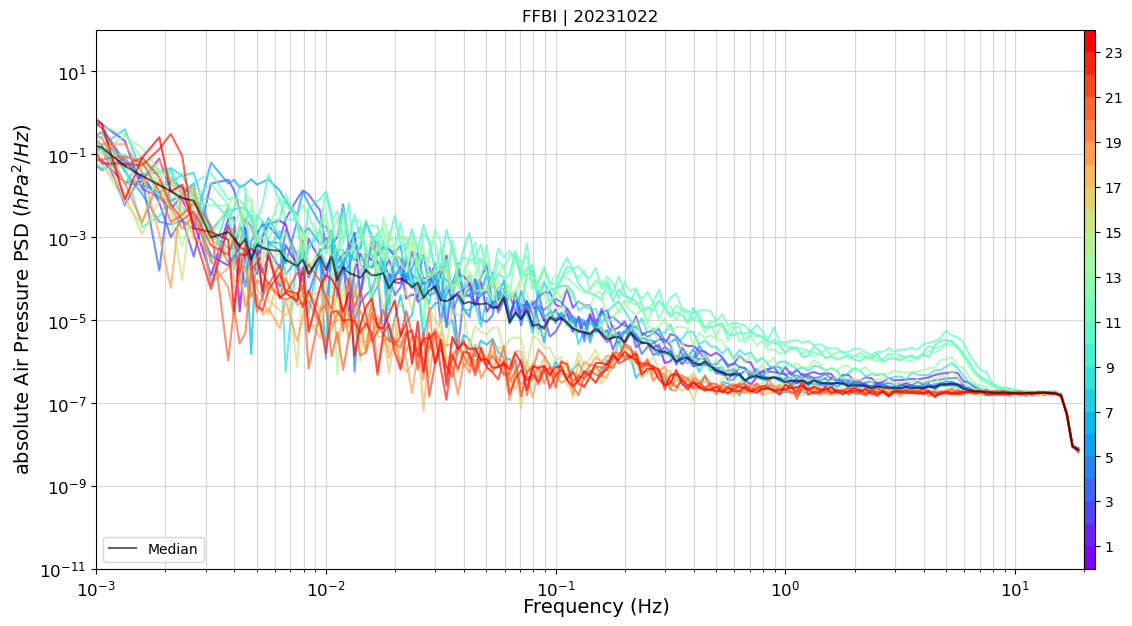

2023_FFBI_3600_20231023_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0
 -> set fmin to 1e-10 instead of 0


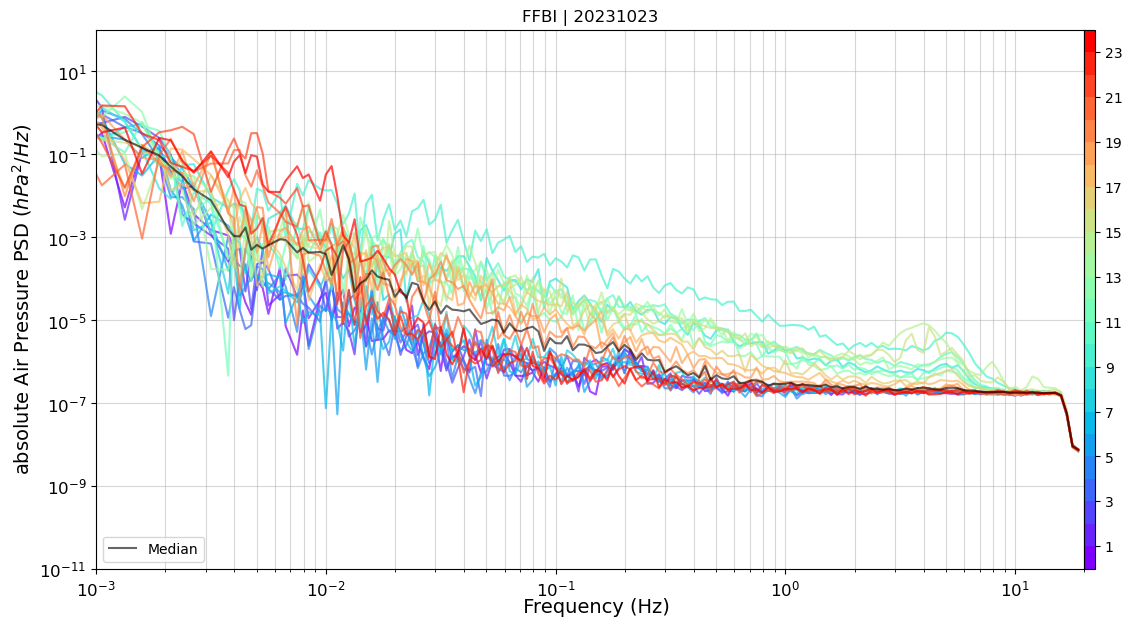

In [16]:
config['files'] = [file for file in os.listdir(config['inpath']) if "hourly" in file]
config['files'].sort()


psds_medians_out, times_out = [], []

for file in config['files']:

    print(file)

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {file} ...")
    #     continue

    day = file.split("_")[-2]

    config['outpath_figname'] = config['station']+f"_{config['inpath'].split('_')[1][:-1]}"+"_"+day

    _ff = pickle.load(open(f"{config['inpath'].replace('Z','Z')}{config['inname'].replace('Z','Z')}_frequency_axis.pkl", 'rb'))

    _psds = __load_data_file(config['inpath'].replace("Z","Z"), file.replace("Z","Z"))

#     _psds, _ff = __cut_frequencies_array(_psds, _ff, config['frequency_limits'][0], config['frequency_limits'][1])

    _psds, rejected = __remove_noisy_psds(_psds, threshold_mean=config['thres'])

    ## get fband averages
    psds = []
    for _n, _psd in enumerate(_psds):
        out0 = __get_fband_average(_ff, _psd, faction_of_octave=12 , average="median", plot=False)
        psds.append(out0['psd_means'])
    ff = out0['fcenter']
    psds = array(psds)


    ## plotting
    fig = __makeplot_colorlines(config, ff,  psds, rejected, day)

    ## save figure
    fig.savefig(config['outpath_figures']+config['outpath_figname']+".png", format="png", transparent=False, dpi=150)


## Store output data

In [17]:
## output data
#     psds_medians_out.append(psds_median)
#     times_out.append(time)

# ## write output
# output = {"times": array(times_out).astype(int), "frequencies": array(ff), "psds_medians": array(psds_medians_out)}

# with open(f"{config['inpath']}{config['inname']}_psds_filtered_medians.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
def __calculate_hist_loglog(psd_array, bins=20, density=False, axis=1, plot=False):

    from numpy import argmax, std, median, isnan, array, histogram, nan, zeros, count_nonzero, isinf, log10
    from scipy.stats import median_abs_deviation as mad

    def __convert_to_log(in_psds):

        out_psds = zeros(in_psds.shape)
        rows_with_zeros = 0

        for i, psd in enumerate(in_psds):
            if count_nonzero(psd) != len(psd):
                rows_with_zeros += 1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = log10(psd)
            if isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        print(f" -> rows with zeros: {rows_with_zeros}")

        return out_psds

    ## converting to log10
    psd_array = __convert_to_log(psd_array)

    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])
    print(f" -> total spectra used: {psd_array.shape[0]}")

    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])
#     print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []

    count = 0
    for h in range(len(psd_array[axis])):

        psd = psd_array[:, h]

        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);

        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])

        ## normalization
#         if True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(SUM*DX) != "1.0":
            count += 1

        ## modify histogram with range increment
        hist = hist*DX

        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist))

        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['mads'] = 10**array(mads)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]

    ## check plot
    if plot:
    # _ff[0] = 1e-21

        fig = plt.figure(figsize=(15, 5))
        cmap = plt.colormaps.get_cmap('viridis')
        cmap.set_under(color='white')
        plt.pcolormesh(_ff, out['bin_mids'], out['dist'].T, cmap=cmap, shading="auto",
                       antialiased=True, vmin=0.9, norm="log")
        plt.yscale("log")
        plt.xscale("log")
        plt.xlim(_ff[1], _ff[-1])

        plt.show();

    if count > 0:
        print(f" -> {count}/{len(psd_array[axis])} errors found for density computation!!!")

    return output

In [19]:
out = __calculate_hist_loglog(_psds, bins=40, density=True, axis=0, plot=True)

 -> rows with zeros: 0
 -> total spectra used: 24


NameError: name 'out' is not defined

<Figure size 1500x500 with 0 Axes>

In [ ]:
bins = out['bin_mids']
dist = out['dist']

In [ ]:
dist.shape, _ff.shape, bins.shape

In [ ]:
cmap = plt.colormaps.get_cmap('viridis')
cmap.set_under(color='white')

_ff[0] = 1e-21

fig = plt.figure(figsize=(15, 5))
plt.pcolormesh(_ff, out['bin_mids'], out['dist'].T, cmap=cmap, shading="auto",
               antialiased=True, vmin=0.9, norm="log")
plt.yscale("log")
plt.xscale("log")
plt.xlim(_ff[1], _ff[-1])